<a href="https://colab.research.google.com/github/LuisIrigoyen/Analyzing-Historical-Data/blob/main/XGBOOST%20-%20REGRESI%C3%93N%20PRECIO%20DE%20INMUEBLES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión con XGBOOST

Los datos usados son datos históricos de mercado de valoración de bienes raíces del distrito de Sindian, New Taipei City, Taiwán.

La idea es entrenar al modelo para predecir el precio de los inmuebles.

El conjunto de datos se dividió aleatoriamente en el conjunto de datos de training (70%) y el conjunto de datos de prueba (30%).

Información de atributos:

* X1 = la fecha de la transacción (por ejemplo, 2013.250=marzo de 2013, 2013.500=junio de 2013, etc.)
* X2 = edad de la casa (unidad: año)
* X3 = la distancia a la estación de tren más cercana (unidad: metros)
* X4 = el número de tiendas de conveniencia en el círculo habitacional a pie (entero)
* X5 = la coordenada geográfica, latitud. (unidad: grado)
* X6 = la coordenada geográfica, longitud. (unidad: grado)

La variable dependiente es la siguiente:

* Y = precio de la vivienda por unidad de área (10000 nuevo dólar taiwanés/Ping, donde Ping es una unidad local, 1 Ping = 3,3 metros cuadrados)

Fuente:

https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb

In [4]:
from google.colab import files

# Esto abrirá un cuadro de diálogo para subir el archivo
uploaded = files.upload()

Saving Real estate valuation data set.xlsx to Real estate valuation data set.xlsx


In [5]:
# Leer archivo
data = pd.read_excel('Real estate valuation data set.xlsx')

## 1) EDA

In [6]:
# ver una muestra del código
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [7]:
data.tail()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
409,410,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5
413,414,2013.500000,6.5,90.45606,9,24.97433,121.54310,63.9


In [8]:
#Evaluar el tamaño del dataset
data.shape

(414, 8)

In [11]:
# Metadata de las variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [10]:
# Variables nulas y faltantes
data.isnull().sum()

,0
No,0
X1 transaction date,0
X2 house age,0
X3 distance to the nearest MRT station,0
X4 number of convenience stores,0
X5 latitude,0
X6 longitude,0
Y house price of unit area,0


In [12]:
data = data.drop(['No'], axis=1)

In [13]:
data.columns = ['date', 'age', 'nearest_station', 'stores', 'latitude', 'longitude', 'price']

In [14]:
# ver una muestra del código
data.head()

,date,age,nearest_station,stores,latitude,longitude,price
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


## 2) Feature Engineering

In [15]:
type(data.date[0])

numpy.float64

In [16]:
import math
# Función para convertir el float a fecha
def convert_float_to_date(float_value):
    year = math.floor(float_value)
    decimal_part = float_value - year
    day_of_year = int(decimal_part * 365.25)  # Aproximación para el día del año
    date = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(days=day_of_year)
    return year, date.month, date.day, date

# Aplicar la función y crear nuevas columnas
data[['year', 'month', 'day', 'date_time']] = data['date'].apply(lambda x: pd.Series(convert_float_to_date(x)))
data.head()

,date,age,nearest_station,stores,latitude,longitude,price,year,month,day,date_time
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9,2012,11,30,2012-11-30
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2,2012,11,30,2012-11-30
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3,2013,8,2,2013-08-02
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8,2013,7,2,2013-07-02
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1,2012,10,31,2012-10-31


In [17]:
#dropeamos las columnas que no vamos a necesitar
data = data.drop(['date','date_time'], axis=1)

## 3) Outliers
Damos una vista general de todas las columnas

In [18]:
import pandas as pd

def detect_outliers_iqr(data):
    outlier_indices = {}

    for column in data.select_dtypes(include=['float64', 'int64']):  # Solo columnas numéricas
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detectar outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_indices[column] = outliers.index.tolist()

    return outlier_indices

# Supongamos que tienes un DataFrame llamado df
outliers = detect_outliers_iqr(data)

# Mostrar los índices de outliers por columna
for col, indices in outliers.items():
    print(f"Outliers en la columna {col}: {indices}")

Outliers en la columna age: []
Outliers en la columna nearest_station: [8, 30, 35, 40, 41, 48, 49, 58, 73, 87, 89, 116, 117, 148, 154, 155, 162, 170, 176, 180, 183, 189, 194, 226, 231, 232, 249, 255, 298, 320, 329, 331, 347, 382, 384, 394, 409]
Outliers en la columna stores: []
Outliers en la columna latitude: [35, 117, 148, 194, 228, 320, 329, 382]
Outliers en la columna longitude: [8, 30, 40, 41, 48, 49, 58, 73, 87, 89, 116, 117, 154, 155, 162, 170, 176, 180, 183, 187, 189, 226, 231, 232, 249, 255, 298, 307, 320, 329, 331, 347, 384, 394, 409]
Outliers en la columna price: [220, 270, 312]
Outliers en la columna year: []
Outliers en la columna month: []
Outliers en la columna day: []


In [19]:

pip install matplotlib seaborn

In [20]:
#vamos a revisar de manera visual también
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

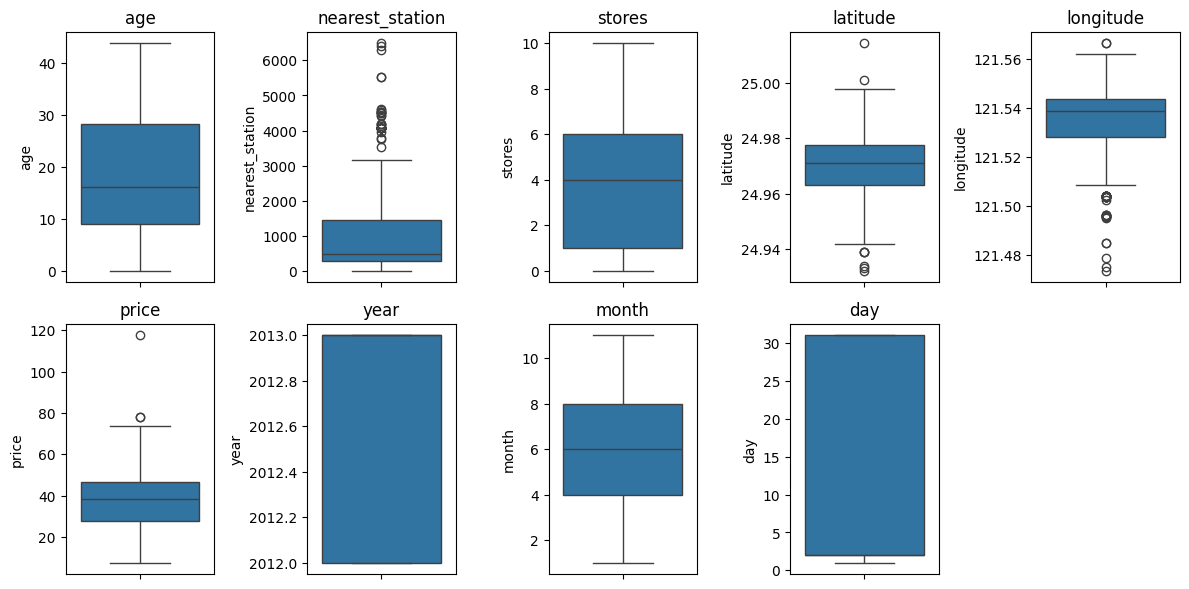

In [21]:
# Supongamos que tienes un DataFrame llamado df
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Crear boxplots
plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns) // 2 + 1, i)
    sns.boxplot(data=data[column])
    plt.title(column)

plt.tight_layout()
plt.show()


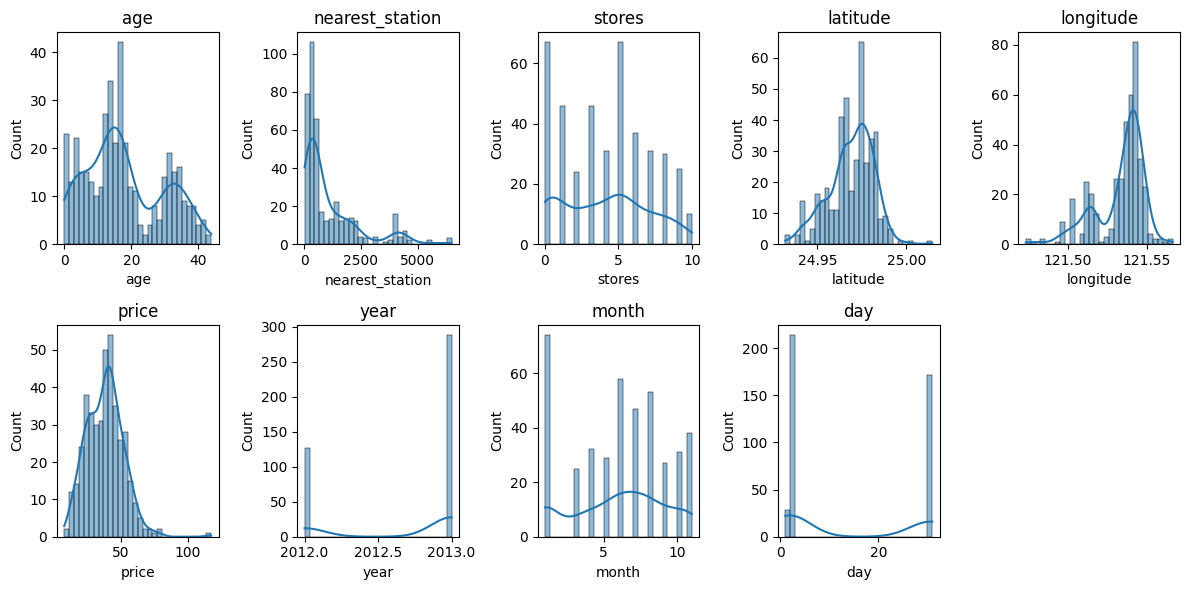

In [22]:
# Crear histogramas
plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns) // 2 + 1, i)
    sns.histplot(data=data[column], bins=30, kde=True)  # kde=True añade una curva de densidad
    plt.title(column)

plt.tight_layout()
plt.show()

<Axes: >

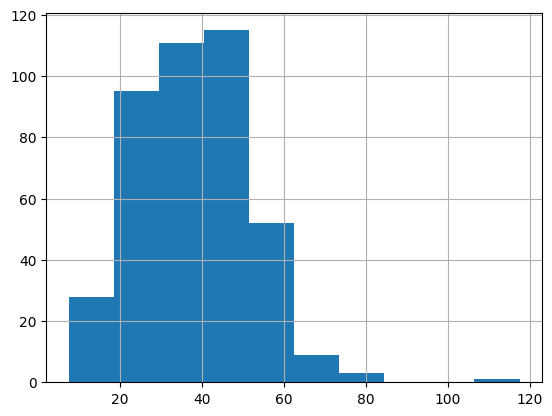

In [23]:
#revisamos price
data['price'].hist()

<Axes: >

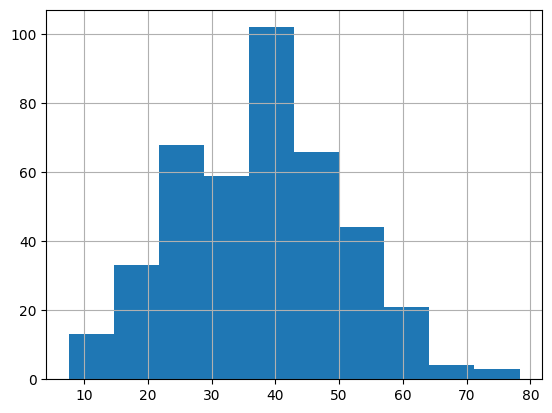

In [24]:
#Quitamos el outlier
data = data[data['price'] < 100]
data['price'].hist()

## 4) Entrenamiento del modelo

seleccionar variables

In [25]:
x = data.drop('price', axis=1)
y = data['price']

Split train and test

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [28]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((289, 8), (124, 8), (289,), (124,))

### Modelo de Regresión

In [29]:
model = XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

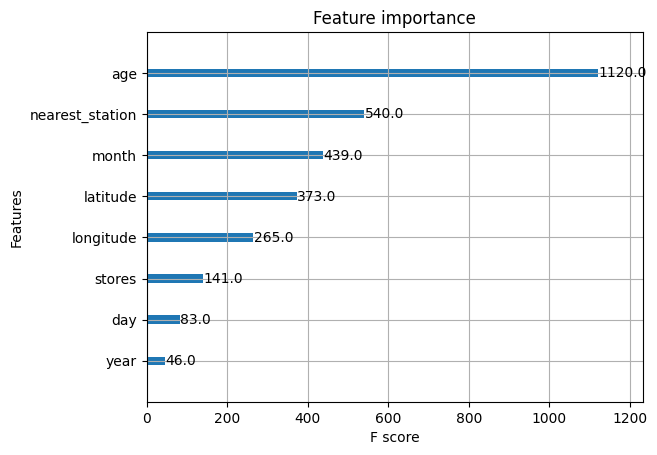

In [30]:
xgb.plot_importance(model, ax=plt.gca())

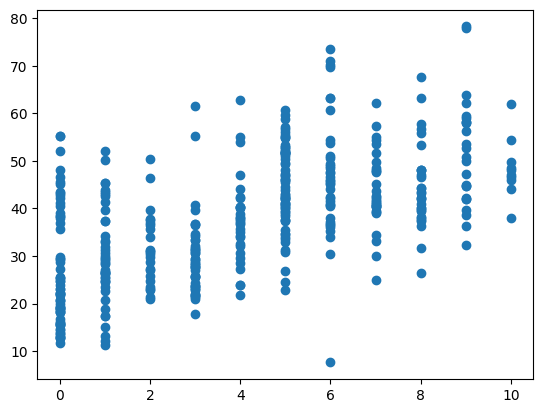

In [31]:
plt.scatter(data["stores"], data["price"])

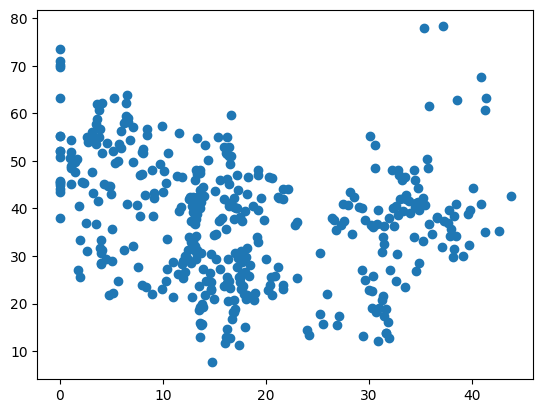

In [32]:
plt.scatter(data["age"], data["price"])

## 5) Evaluación de desempeño del modelo

Vamos a usar 2 coeficientes:
coeficiente de determinación "R cuadrado" y el "Error cuadrático medio". RSME.

### Desempeño del entrenamiento

In [33]:
prediccion_entrenamiento = model.predict(x_train)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_train, prediccion_entrenamiento))

0.9970792054874149


In [35]:
print(mean_squared_error(y_train, prediccion_entrenamiento))

0.48211867224489446


### Desempeño del test

In [36]:
prediccion_test = model.predict(x_test)

In [37]:
print(r2_score(y_test, prediccion_test))

0.7171606118266988


In [38]:
print(mean_squared_error(y_test, prediccion_test))

51.08217311869973


Se obtubo un resultado aceptable en ambos indicadores, pero que el entrenamiento de 0.99 de r2 y luego la diferencia entre entrenamiento y test indica un overfitting.

Vamos a revisar de manera visual la relación entre la predicción del modelo en el test y el valor real del precio.



Text(0.5, 1.0, 'Relación entre Valor Real y Predicción')

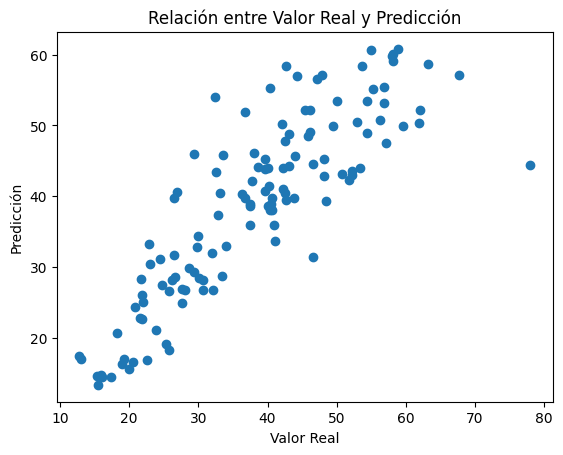

In [39]:
plt.scatter(y_test, prediccion_test)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Relación entre Valor Real y Predicción')